In [1]:
import cv2
import urllib.request 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import albumentations as alb 
import json
import os

Rename file


In [ ]:
count = 198
for file in os.listdir(os.path.join('Data_Raw', 'Long')) :
  # print(file)
  
  file_name = os.path.join('Data_Raw', 'Long', file)
  
  new_file = file.split('roi')[0] + f'roi{count}.jpg'
  
  dest = os.path.join('Data_Raw', 'Long', new_file)
  
  os.rename(file_name, dest)
  count += 1

Apply Image Augmentation on Images and Labels using Albumentations


In [3]:
# Setup Albumentations Transform 
augmentor = alb.Compose([
  alb.RandomCrop(width=450, height=450),
  alb.HorizontalFlip(p=0.5),
  alb.VerticalFlip(p=0.5),
  alb.RandomBrightnessContrast(p=0.2),
  alb.RandomGamma(p=0.2),
  alb.RGBShift(p=0.2),],
  bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels'])
)

In [21]:
image = cv2.imread(os.path.join('Data_Train', 'Long', 'z51985795_roi4.jpg'))
# image

In [5]:
# get coordinate from label file
with open(os.path.join('Data_Train', 'Long_Label', 'z51985795_roi4.json'), 'rb') as file :
  label = json.load(file)
print({
  "points" : label["shapes"][0]['points'],
  "fileName" : label["imagePath"].split('\\')[2]
})  
# coordinate = [0,0,0,0]
# coordinate[0] = label['shapes'][0]['points'][0][0]
# coordinate[1] = label['shapes'][0]['points'][0][1]
# coordinate[2] = label['shapes'][0]['points'][1][0]
# coordinate[3] = label['shapes'][0]['points'][1][1]

# Normalization
# coordinate = list(np.divide(coordinate, [640,480,640,480]))
# print(coordinate)

{'points': [[262.55952380952385, 176.9047619047619], [406.6071428571429, 376.30952380952385]], 'fileName': 'z51985795_roi4.jpg'}


In [24]:
# Apply augmentation and view results
augmented = augmentor(image=image, bboxes=[coordinate], class_labels=['Long'])
# print(augmented['image'])
print(augmented['class_labels'][0])
# print(augmented['points'])

Long


Build and Run Augmentation Pipeline


In [5]:
# Run Augmentation Pipeline
for folder in ['Data_Train', 'Data_Test', 'Data_Validation'] :
  for image_file in os.listdir(os.path.join(folder, 'Quoc')) :
    image = cv2.imread(os.path.join(folder, 'Quoc', image_file))
    
    coords = [0,0,0.0001,0.00001]
    label_path = os.path.join(folder, 'Quoc_Label', f'{image_file.split(".")[0]}.json')
    # print(label_path)
    if os.path.exists(label_path) :
      with open (label_path, 'rb') as file :
        label = json.load(file)
        # print(label)
      coords[0] = label['shapes'][0]['points'][0][0]
      coords[1] = label['shapes'][0]['points'][0][1]
      coords[2] = label['shapes'][0]['points'][1][0]
      coords[3] = label['shapes'][0]['points'][1][1]
      
      coords = list(np.divide(coords, [640,480,640,480]))
      
    try:
      for x in range(10) :
        # print(x)
        augmented = augmentor(image=image, bboxes=[coords], class_labels=['Quoc'])
        cv2.imwrite(os.path.join('Data_Augmented', folder, 'Quoc', f'{image_file.split(".")[0]}.{x}.jpg'), augmented['image'])

        annotation = {
          'image_file': '',
          'bbox': '',
          'class': '',
          'label': ''
        }
        annotation['image_file'] = image_file
        
        if os.path.exists(label_path) :
          if len(augmented['bboxes']) == 0 :
            annotation['bbox'] = [0,0,0,0]
            annotation['class'] = 0
          else :
            annotation['bbox'] = augmented['bboxes'][0]
            annotation['class'] = 1
            annotation['label'] = augmented['class_labels'][0]
        else :
          annotation['bbox'] = [0,0,0,0]
          annotation['class'] = 0
          
        with open(os.path.join('Data_Augmented', folder, 'quoc_label', f'{image_file.split(".")[0]}.{x}.json'), 'w') as f :
          json.dump(annotation, f)
    except Exception as e :
      print(e)

Load Augmented Images to Tensorflow Dataset


In [3]:
def load_image(file_path)  :
  byte_image = tf.io.read_file(file_path)
  image = tf.io.decode_jpeg(byte_image)
  return image

In [16]:
def load_images_from_folder(folder):
  images = []
  for filename in os.listdir(folder):
    if filename.endswith(".jpg"):
      img = cv2.imread(os.path.join(folder, filename))
      if img is not None:
        images.append(img)
  return images

In [42]:
train_images = tf.data.Dataset.list_files('Data_Augmented\\Data_Train\\quoc\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x : tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x : x/255) 

len(train_images)

2170

In [43]:
test_images = tf.data.Dataset.list_files('Data_Augmented\\Data_Test\\quoc\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x : tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x : x/255)
# test_images.as_numpy_iterator().next()
len(test_images)

570

In [44]:
val_images = tf.data.Dataset.list_files('Data_Augmented\\Data_Validation\\quoc\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x : tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x : x/255)
# val_images.as_numpy_iterator().next()
len(val_images)

570

Prepare Labels


In [7]:
def load_label(label_path) :
  with open(label_path.numpy(), 'rb') as file :
    label = json.load(file)
  return [label['class']], label['bbox'], label['label']

In [45]:
train_labels = tf.data.Dataset.list_files('Data_Augmented\\Data_Train\\quoc_label\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x : tf.py_function(load_label, [x], [tf.uint8, tf.float16, tf.string]))
# train_labels.as_numpy_iterator().next()
len(train_labels)

2170

In [46]:
test_labels = tf.data.Dataset.list_files('Data_Augmented\\Data_Test\\quoc_label\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x : tf.py_function(load_label, [x], [tf.uint8, tf.float16, tf.string]))
# test_labels.as_numpy_iterator().next()[2].decode()
len(test_labels)

570

In [47]:
val_labels = tf.data.Dataset.list_files('Data_Augmented\\Data_Validation\\quoc_label\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x : tf.py_function(load_label, [x], [tf.uint8, tf.float16, tf.string]))
# val_labels.as_numpy_iterator().next()
len(val_labels)

570

Combine Label and Image Samples


In [48]:
#  Check length of partitions
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels) 

(2170, 2170, 570, 570, 570, 570)

In [49]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
# train.as_numpy_iterator().next()
# train.as_numpy_iterator().next()[1]

In [50]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)
# test.as_numpy_iterator().next()[0].shape
# test.as_numpy_iterator().next()[1]

In [51]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1300)
val = val.batch(8)
val = val.prefetch(4)
# val.as_numpy_iterator().next()[0].shape
# val.as_numpy_iterator().next()[1]

View Images and Annotations


In [ ]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

# for idx in range(4) :
# print(res[1][1][1])

fig, ax = plt.subplots(ncols = 4, figsize=(20, 20))
for idx in range(4) :
  image_sample = np.array(res[0][idx])
  bbox_sample = res[1][1][idx]
  
  cv2.rectangle(
    image_sample,
    tuple(np.multiply(bbox_sample[:2], [450,450]).astype(int)),
    tuple(np.multiply(bbox_sample[2:], [450,450]).astype(int)),
    (255,0,0),
    2 
  )
  
  ax[idx].imshow(image_sample)

Build Deep Learning using the Functional API


In [2]:
# Import Layers and Base Network
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from keras.applications import VGG16


In [16]:
# Download VGG16
vgg = VGG16(include_top = False)
# vgg.summary()

In [17]:
# Build instance of Network
def build_model() :
  input_layer = Input(shape=(120,120,3))
  
  vgg = VGG16(include_top = False)(input_layer)
  
  # Classification Model
  f1 = GlobalMaxPooling2D()(vgg)
  class1 = Dense(2048, activation='relu')(f1)
  class2 = Dense(1, activation='sigmoid')(class1)
  
  #Bounding Box Model
  f2 = GlobalMaxPooling2D()(vgg)
  regress1 = Dense(2048, activation='relu')(f2)
  regress2 = Dense(4, activation='sigmoid')(regress1)
  
  return Model(inputs=input_layer, outputs=[class2, regress2])

In [18]:
# Test out Neural Network
face_tracker = build_model()
# face_tracker.summary()

In [ ]:
Xtrain, ytrain = train.as_numpy_iterator().next()
ytrain

In [ ]:
classes, coords = face_tracker.predict(Xtrain)


Define Losses and Optimizers


In [19]:
# Define Optimizer and Learning rate decay
batches_per_epoch = len(train)
learning_rate_decay = (1./0.75 - 1)/batches_per_epoch

In [20]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=learning_rate_decay)

In [21]:
# Create Localization Loss and Classification Loss
def localization_loss(y_true, yhat) :
  delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
  
  height_true = y_true[:,3] - y_true[:,1]
  width_true = y_true[:,2] - y_true[:,0]
  
  height_predicted = yhat[:,3] - yhat[:,1]
  width_predicted = yhat[:,2] - yhat[:,0]
  
  delta_size = tf.reduce_sum(tf.square(width_true - width_predicted) + tf.square(height_true - height_predicted))
  
  return delta_coord + delta_size

class_loss = tf.keras.losses.BinaryCrossentropy()
regress_loss = localization_loss

In [55]:
# Test out Loss Metrics
class_loss(ytrain[0], classes), regress_loss(ytrain[1], coords)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.6626317>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.048875>)

Train Neural Network


In [22]:
# Create Custom Model Class
class FaceTracker(Model) :
  def __init__(self, model, **kwargs):
    super().__init__(**kwargs)
    self.model = model
    
  def compile(self, opt, classloss, localizationloss, **kwargs) :
    super().compile(**kwargs)
    self.opt = opt
    self.classloss = classloss
    self.localizationloss = localizationloss
    
  def train_step(self, batch, **kwargs) :
    Xtrain, ytrain = batch
    
    with tf.GradientTape() as tape :
      classes, coords = self.model(Xtrain, training=True)
      
      batch_classloss = self.classloss(ytrain[0], classes)
      batch_localizationloss = self.localizationloss(tf.cast(ytrain[1], tf.float32), coords)
      
      total_loss = batch_localizationloss + 0.5 * batch_classloss
      
      grad = tape.gradient(total_loss, self.model.trainable_variables)
    
    opt.apply_gradients(zip(grad, self.model.trainable_variables))
    
    return {
      "total_loss" : total_loss,
      "class_loss" : batch_classloss,
      "regress_loss" : batch_localizationloss
    }
    
  def test_step(self, batch, **kwargs) :
    Xtest, ytest = batch
    
    classes, coords = self.model(Xtest, training=False)
    
    batch_classloss = self.classloss(ytest[0], classes)
    batch_localizationloss = self.localizationloss(tf.cast(ytest[1], tf.float32), coords)
      
    total_loss = batch_localizationloss + 0.5 * batch_classloss
    
    return {
      "total_loss" : total_loss,
      "class_loss" : batch_classloss,
      "regress_loss" : batch_localizationloss
    }
    
  def call(self, X, **kwargs) :
    return self.model(X, **kwargs)
  

In [23]:
model = FaceTracker(face_tracker)

In [24]:
model.compile(opt, class_loss, regress_loss)

In [52]:
# Train
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs = 30, validation_data = val, callbacks = [tensorboard_callback])                                                          

Epoch 1/30
272/272 [==============================] - 1468s 5s/step - total_loss: 0.0934 - class_loss: 0.0463 - regress_loss: 0.0702 - val_total_loss: 0.0060 - val_class_loss: 4.7982e-06 - val_regress_loss: 0.0060
Epoch 2/30
272/272 [==============================] - 1296s 5s/step - total_loss: 0.0349 - class_loss: 0.0129 - regress_loss: 0.0284 - val_total_loss: 0.0024 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0024
Epoch 3/30
272/272 [==============================] - 1041s 4s/step - total_loss: 0.0198 - class_loss: 0.0080 - regress_loss: 0.0158 - val_total_loss: 0.0042 - val_class_loss: 0.0017 - val_regress_loss: 0.0033
Epoch 4/30
272/272 [==============================] - 926s 3s/step - total_loss: 0.0135 - class_loss: 0.0051 - regress_loss: 0.0109 - val_total_loss: 0.0013 - val_class_loss: 1.8627e-05 - val_regress_loss: 0.0012
Epoch 5/30
272/272 [==============================] - 1006s 4s/step - total_loss: 0.0113 - class_loss: 0.0045 - regress_loss: 0.0091 - val_total_loss

Plot performance


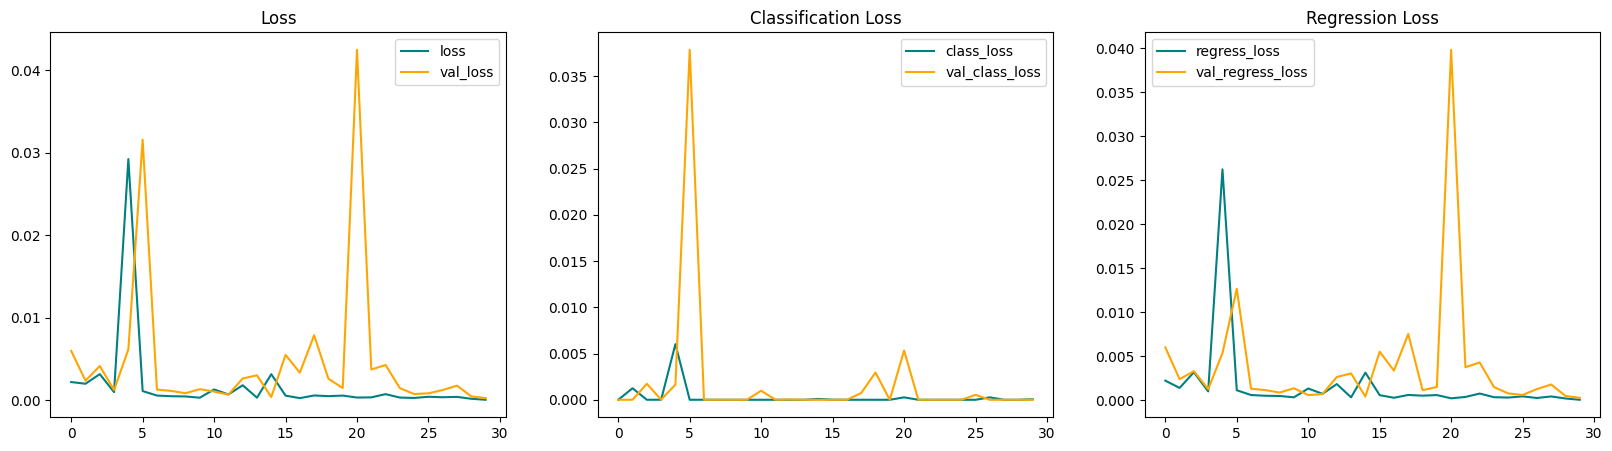

In [53]:
fig, ax = plt.subplots(ncols = 3, figsize = (20,5))

ax[0].plot(hist.history['total_loss'], color = 'teal', label = 'loss')
ax[0].plot(hist.history['val_total_loss'], color = 'orange', label = 'val_loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color = 'teal', label = 'class_loss')
ax[1].plot(hist.history['val_class_loss'], color = 'orange', label = 'val_class_loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color = 'teal', label = 'regress_loss')
ax[2].plot(hist.history['val_regress_loss'], color = 'orange', label = 'val_regress_loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

Make Prediction


In [ ]:
# Make prediction on Test set
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

yhat = face_tracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx in range(4) :
  sample_image = np.array(test_sample[0][idx])
  sample_coords = yhat[1][idx]
  
  if yhat[0][idx] > 0.5 :
    cv2.rectangle(
      sample_image,
      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
      (255,0,0),
      1 
    )
  ax[idx].imshow(sample_image)

Save model

In [54]:
face_tracker.save('Quoc.h5')

Real time detection

In [ ]:
def performFaceDetection(vid) :
  facetracker = load_model('Quoc.h5')
  
  while True :
    result, frame = vid.read()
    if result is False:
      break
    frame = frame[50 : 500, 50 : 500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255, 0))
    print(yhat)
    sample_coords = yhat[1][0]
  
    if yhat[0] > 0.5 :
      # Control the main rectangle
      cv2.rectangle(
        frame,
        tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
        tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
        (255,0,0),
        2 
      )
    
    cv2.imshow("My Face Detection Project", frame) 
    if cv2.waitKey(1) & 0xFF == ord("q"):
      break
    
  vid.release()
  cv2.destroyAllWindows()
  
def accessCamera(IP_Stream) :
  return cv2.VideoCapture(IP_Stream)

# url = 'http://192.168.1.105'
video_stream = accessCamera(0)
performFaceDetection(video_stream)